In [1]:
import numpy as np
import math
import prune
import os
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm

#create ./image_output/ folder if your want to store iamges!

os.environ["OMP_NUM_THREADS"] = "1" #remove if run of GPU
mp = prune.ModelPruner('MNIST', 'by_channel')
print(mp.baseline)

Load model: ./model_weights/vgg11_MNIST.pt...
validating...


100%|██████████| 10/10 [27:20<00:00, 164.03s/it]

{'loss': 0.14459533095359803, 'acc': 96.40625}


In [10]:


# the phony generator
def generator(in_arr):
    pruned_model = mp.prune_model(in_arr)
    return mp.get_fitness_score(pruned_model)

def N_step_single_pass(decision_len, deci_arr_in, stepsize_arr_in, tau_prum_in, tau_in, elpslon_zero):
    random_normal_i = np.random.normal(0, 1, size=(decision_len))
    random_normal = np.random.normal(0, 1, size=(1))
    
    #store input variable
    deci_arr = np.copy(deci_arr_in)
    stepsize_arr = np.copy(stepsize_arr_in)
    
    for i in range(decision_len):
        stepsize_arr[i]*=math.exp(tau_prum_in*random_normal[0]+tau_in*random_normal_i[i])

        if(stepsize_arr[i] > elpslon_zero):
            deci_arr[i] += stepsize_arr[i]*random_normal_i[i]
        else:
            deci_arr[i] += elpslon_zero*random_normal_i[i]

        if(deci_arr[i] <= 0.001):
            deci_arr[i] = 0.001
        elif(deci_arr[i] >= 0.999):
            deci_arr[i] = 0.999

    return deci_arr, stepsize_arr


def ESXPlusX_NS(Decision_var_record, Stepsize_record, Best_score_record,
                Decision_arr_init, Stepsize_arr_init,
                Target_run, child_lambda, hp_tau_prum, hp_tau, hp_elpslon_zero):
    train_runs = 0
    
    decision_var_arr = np.copy(Decision_arr_init)
    stepsize_arr = np.copy(Stepsize_arr_init)
    best_score = generator(decision_var_arr)

    
    tau_in = hp_tau/((1/math.sqrt(2*len(Decision_arr_init))))
    tau_prum_in = hp_tau_prum/math.sqrt(2*math.sqrt(len(Decision_arr_init)))

    while(train_runs < Target_run):
        print(f'Training epoch: {train_runs+1}/{Target_run}')
        memorize_parent_decision_var_arr = np.copy(decision_var_arr)
        memorize_parent_stepsize_arr = np.copy(stepsize_arr)
 
        for run in range(child_lambda):
            tmp_decision_var_arr, tmp_stepsize = N_step_single_pass(len(Decision_arr_init),memorize_parent_decision_var_arr,memorize_parent_stepsize_arr,
                                                                    tau_prum_in, tau_in, hp_elpslon_zero)
            tmp_score = generator(tmp_decision_var_arr)


            if(tmp_score < best_score):
                best_score = tmp_score
                decision_var_arr = np.copy(tmp_decision_var_arr)
                stepsize_arr = tmp_stepsize
        Decision_var_record.append(decision_var_arr)
        Stepsize_record.append(stepsize_arr)
        Best_score_record.append(best_score)
        train_runs+=1

    return decision_var_arr, stepsize_arr, best_score




In [11]:
#Hyperparameters could be change here:

HP_DECISION_INITVAL = 0.5   # Initial value for decision variable (array)
HP_STEPSIZE_INITVAL = 0.1   # Initial value for stepsize (array)
HP_ITERATIONS = 5           # Run how many iterations/epoch
HP_CHILD_LAMBDA = 2         # Run (1+child_lambda)-EC
HP_TAU_PRUM_PARAM = 0.05    # global step size changing parameter, tau_prum = HP_TAU_PRUM_PARAM/sqrt(2*sqrt(N))
HP_TAU_PARAM = 0.05         # local step size changing parameter, tau = HP_TAU_PARAM/sqrt(2*N)
HP_ELPSLON_VALUE = 0.001    # The threshold of the step size, if stepsize < elpslon, stepsize=elpslon


#auto generated parameter (Don't change)
Decision_arr = np.array([HP_DECISION_INITVAL for i in range(mp.prunable_layer_num)]) 
Stepsize_arr = np.array([HP_STEPSIZE_INITVAL for i in range(mp.prunable_layer_num)]) 


DV_record = [] #records the decision variable of each epoch
SZ_record = [] #records the step size of each epoch
BS_reocrd = [] #records the best solution of each run

#run EC algorithm
ans_decvar, ans_stepsize, ans_bestscore = ESXPlusX_NS(Decision_var_record=DV_record,Stepsize_record=SZ_record,Best_score_record=BS_reocrd, 
            Decision_arr_init=Decision_arr,Stepsize_arr_init=Stepsize_arr,
            Target_run=HP_ITERATIONS,child_lambda=HP_CHILD_LAMBDA,
            hp_tau_prum=HP_TAU_PRUM_PARAM, hp_tau=HP_TAU_PARAM, hp_elpslon_zero=HP_ELPSLON_VALUE)


print(DV_record)
print(SZ_record)
print(BS_reocrd)



pruning...
validating...


100%|██████████| 10/10 [02:37<00:00, 15.74s/it]


acc: 96.875
loss: 0.13475070223212243
sparsity: 0.250104151700836
Training epoch: 1/5
pruning...
validating...


100%|██████████| 10/10 [03:29<00:00, 20.98s/it]


acc: 10.9375
loss: 2.3043481588363646
sparsity: 0.23600797147329516
pruning...
validating...


100%|██████████| 10/10 [02:03<00:00, 12.32s/it]


acc: 97.03125
loss: 0.43649728298187257
sparsity: 0.22711669010451938
Training epoch: 2/5
pruning...
validating...


100%|██████████| 10/10 [02:07<00:00, 12.78s/it]


acc: 97.8125
loss: 0.11332247033715248
sparsity: 0.14508947186582724
pruning...
validating...


100%|██████████| 10/10 [02:42<00:00, 16.25s/it]


acc: 9.84375
loss: 2.2968005418777464
sparsity: 0.30080199022251114
Training epoch: 3/5
pruning...
validating...


100%|██████████| 10/10 [02:14<00:00, 13.41s/it]


acc: 8.90625
loss: 3.000032639503479
sparsity: 0.18730656473787285
pruning...
validating...


100%|██████████| 10/10 [00:28<00:00,  2.85s/it]


acc: 97.1875
loss: 0.4898783951997757
sparsity: 0.0989187367989825
Training epoch: 4/5
pruning...
validating...


100%|██████████| 10/10 [04:08<00:00, 24.85s/it]


acc: 8.59375
loss: 2.3165409326553346
sparsity: 0.06824015867547141
pruning...
validating...


100%|██████████| 10/10 [02:10<00:00, 13.05s/it]


acc: 95.9375
loss: 0.20109995156526567
sparsity: 0.04567438123424458
Training epoch: 5/5
pruning...
validating...


100%|██████████| 10/10 [02:38<00:00, 15.88s/it]


acc: 11.5625
loss: 2.306239104270935
sparsity: 0.013543696038484028
pruning...
validating...


100%|██████████| 10/10 [02:05<00:00, 12.55s/it]

acc: 97.03125
loss: 0.12315362542867661
sparsity: 0.12465676442297458
[array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]), array([0.42073517, 0.58680418, 0.49745457, 0.62192137, 0.59022134,
       0.66136054, 0.51009496, 0.51551736, 0.70764458, 0.51370594]), array([0.42073517, 0.58680418, 0.49745457, 0.62192137, 0.59022134,
       0.66136054, 0.51009496, 0.51551736, 0.70764458, 0.51370594]), array([0.45370196, 0.53328606, 0.4934472 , 0.55653947, 0.68222248,
       0.61301544, 0.40414435, 0.49257076, 0.9378154 , 0.37031836]), array([0.45370196, 0.53328606, 0.4934472 , 0.55653947, 0.68222248,
       0.61301544, 0.40414435, 0.49257076, 0.9378154 , 0.37031836])]
[array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]), array([0.08089832, 0.11861914, 0.10014321, 0.1252127 , 0.11927423,
       0.13229337, 0.10294673, 0.10412661, 0.14024107, 0.10373391]), array([0.08089832, 0.11861914, 0.10014321, 0.1252127 , 0.11927423,
       0.13229337, 0.10294673, 0.10412661, 0.14024107, 0.103733

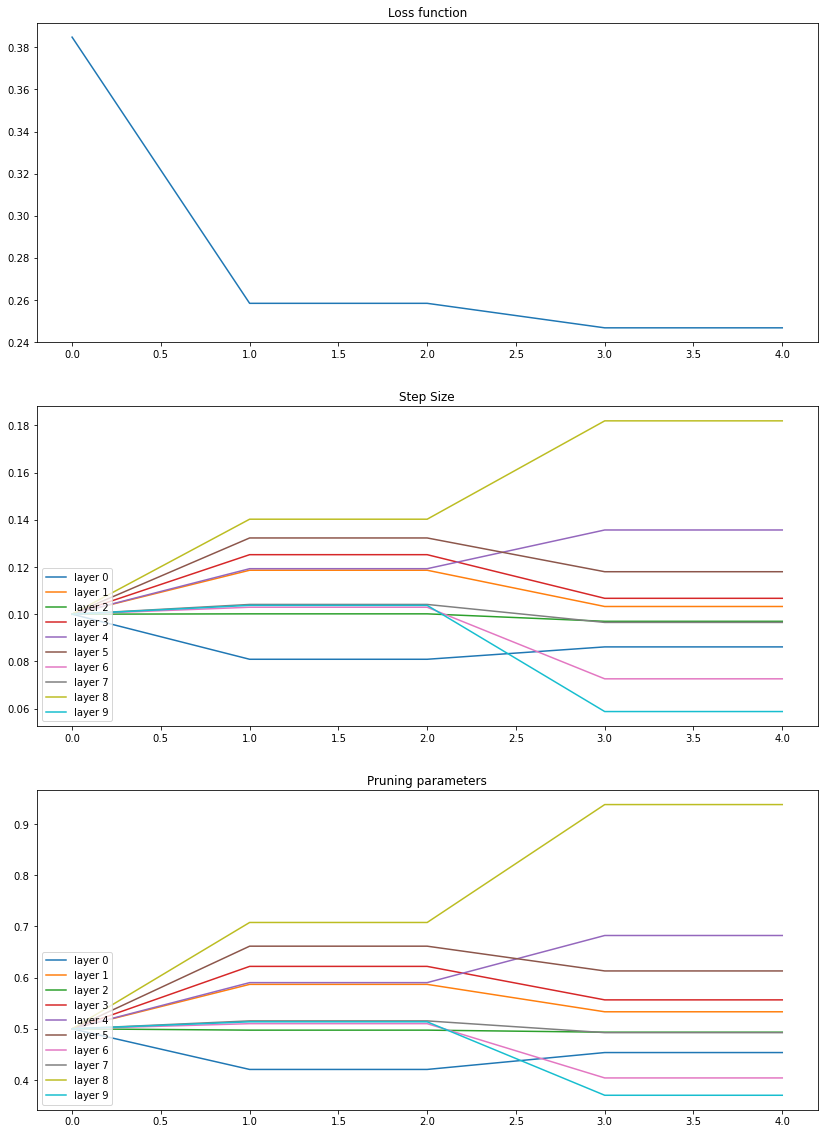

In [13]:
#visualize the result
def plotOSResult(arr1, arr2d_1, arr2d, model_name):
    run_num = len(arr1)
    parm_num = len(arr2d[0])
    plt.figure(figsize=(14,20))
    
    ax1 = plt.subplot(311)
    ax1.plot(arr1)
    ax1.set_title('Loss function')

    ax2 = plt.subplot(312)
    for line in range(parm_num):
        ax2.plot([arr2d_1[j][line] for j in range(run_num)], label = f'layer {line}')
    ax2.set_title('Step Size')
    ax2.legend(loc=3)

    ax3 = plt.subplot(313)
    for line in range(parm_num):
        ax3.plot([arr2d[j][line] for j in range(run_num)], label = f'layer {line}')

    ax3.set_title('Pruning parameters')    
    ax3.legend(loc=3)   

    now=datetime.now()
    time_print=now.strftime("%Y-%m-%d %H:%M:%S")
    #change the saving directory if your want to
    plt.savefig(f'./image_output/{model_name}NStepEC_{run_num}runs_{time_print}.png',dpi = 400)
    plt.show()
    

plotOSResult(BS_reocrd,SZ_record,DV_record,"VGG11")

